# IQ Files & SigMF

While it’s possible to store the complex numbers in a text file or csv file, we prefer to save them in what’s called a “binary file” to save space. At high sample rates your signal recordings could easily be multiple GB, and we want to be as memory efficient as possible.

In Python, the default complex type is np.complex128, which uses two 64-bit floats per sample. But in DSP/SDR, we tend to use 32-bit floats instead because the ADCs on our SDRs don’t have that much precision to warrant 64-bit floats. In Python we will use np.complex64, which uses two 32-bit floats. When you are simply processing a signal in Python it doesn’t really matter, but when you go to save the 1d array to a file, you want to make sure it’s an array of np.complex64 first.


In Python, and numpy specifically, we use the tofile() function to store a numpy array to a file. Here is a short example of creating a simple BPSK signal plus noise and saving it to a file in the same directory we ran our script from:

[-1.01571119+0.01168553j  0.9768507 -0.07908536j -1.05376596-0.20570976j
 ...  1.10451155+0.03279887j  0.97773194-0.0285322j
  0.87263944+0.00407851j]


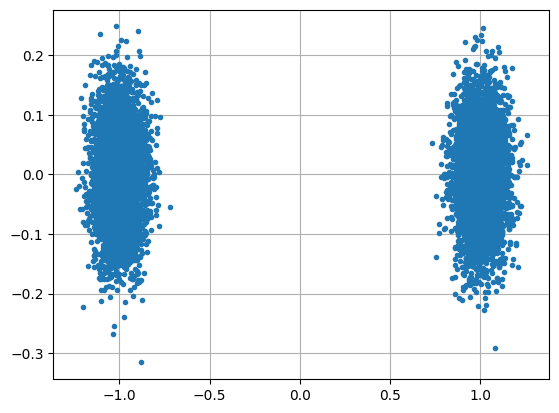

<class 'numpy.complex128'>
<class 'numpy.complex64'>


In [4]:
import numpy as np
import matplotlib.pyplot as plt

num_symbols = 10000

# array of 1 and -1
x_sym = np.random.randint(0, 2, num_symbols)*2-1 
# AWGN with unity power
n = (np.random.randn(num_symbols) + 1j*np.random.randn(num_symbols)) \
    /np.sqrt(2) 

r = x_sym + n * np.sqrt(0.01) # noise power of 0.01
print(r)
plt.plot(np.real(r), np.imag(r), '.')
plt.grid(True)
plt.show()
print(type(r[0])) # Check data type.  Oops it's 128 not 64!
r = r.astype(np.complex64) # Convert to 64
print(type(r[0])) # Verify it's 64
r.tofile('bpsk_in_noise.iq') # Save to file

Now examine the details of the file produced and check how many bytes it is. It should be num_symbols * 8 because we used np.complex64, which is 8 bytes per sample, 4 bytes per float (2 floats per sample).

Using a new Python script, we can read in this file using np.fromfile(), like so:

[-1.0157112 +0.01168553j  0.9768507 -0.07908536j -1.053766  -0.20570976j
 ...  1.1045115 +0.03279887j  0.97773194-0.0285322j
  0.8726394 +0.00407851j]


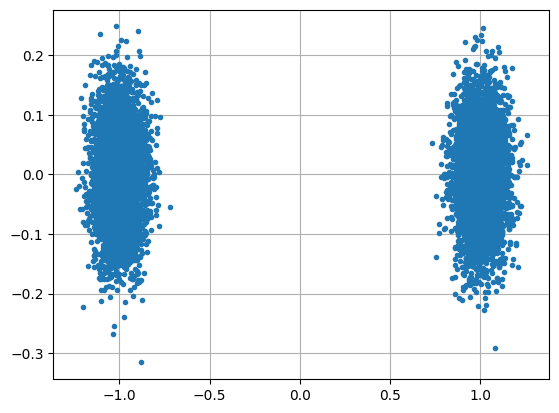

In [5]:
import numpy as np
import matplotlib.pyplot as plt

samples = np.fromfile('bpsk_in_noise.iq', np.complex64) # Read in file.  We have to tell it what format it is
print(samples)

# Plot constellation to make sure it looks right
plt.plot(np.real(samples), np.imag(samples), '.')
plt.grid(True)
plt.show()

If you ever find yourself dealing with int16’s (a.k.a. short ints), or any other datatype that numpy doesn’t have a complex equivalent for, you will be forced to read the samples in as real, even if they are actually complex. The trick is to read them as real, but then interleave them back into the IQIQIQ… format yourself, a couple different ways of doing this are shown below:

In [ ]:
samples = np.fromfile('iq_samples_as_int16.iq', np.int16).astype(np.float32).view(np.complex64)
#  OR
samples = np.fromfile('iq_samples_as_int16.iq', np.int16)
samples = samples / 32768 # convert to -1 to +1 (optional)
samples = samples[::2] + 1j*samples[1::2] # convert to IQIQIQ...